In [1]:
import numpy as np
import tensorflow_probability as tfp
from PIL import Image, ImageDraw, ImageFont, ImageFilter
import matplotlib.pyplot as plt
import math
import os
import random
import string
import logging
import math
import cv2

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
import pathlib

logging.getLogger('tensorflow').setLevel(logging.ERROR)  # suppress warnings
# connect to TPU
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='local')
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)
strategy = tf.distribute.TPUStrategy(resolver)

D0905 06:13:05.090082129 1868236 config.cc:119]                        gRPC EXPERIMENT tcp_frame_size_tuning               OFF (default:OFF)
D0905 06:13:05.090105811 1868236 config.cc:119]                        gRPC EXPERIMENT tcp_rcv_lowat                       OFF (default:OFF)
D0905 06:13:05.090130981 1868236 config.cc:119]                        gRPC EXPERIMENT peer_state_based_framing            OFF (default:OFF)
D0905 06:13:05.090136223 1868236 config.cc:119]                        gRPC EXPERIMENT flow_control_fixes                  ON  (default:ON)
D0905 06:13:05.090140925 1868236 config.cc:119]                        gRPC EXPERIMENT memory_pressure_controller          OFF (default:OFF)
D0905 06:13:05.090145568 1868236 config.cc:119]                        gRPC EXPERIMENT unconstrained_max_quota_buffer_size OFF (default:OFF)
D0905 06:13:05.090150125 1868236 config.cc:119]                        gRPC EXPERIMENT new_hpack_huffman_decoder           ON  (default:ON)
D0905 06:13:05.

In [2]:
images = []
file_names = []
for file_name in os.listdir('images'):
    if file_name.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
        image_path = os.path.join('images', file_name)
        image = cv2.imread(image_path)
        image = cv2.resize(image, (400, 800))
        image = cv2.resize(image, (576, 1024))
        # image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        images.append(image)
        file_names.append(file_name)

blurry = []
for ims in images:
    gaussian = cv2.GaussianBlur(ims, (29, 29), 0)
    blurry.append(gaussian)

In [30]:
def save_images_to_folder(images, file_names, output_folder):

    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for idx, img in enumerate(images):
        output_path = os.path.join(output_folder, file_names[idx])
        cv2.imwrite(output_path, img)
        print(f"Saved {output_path}")

save_images_to_folder(blurry, file_names, 'new_images')

Saved new_images/frame_96.jpg
Saved new_images/frame_599.jpg
Saved new_images/frame_292.jpg
Saved new_images/frame_1014.jpg
Saved new_images/frame_322.jpg
Saved new_images/frame_49.jpg
Saved new_images/frame_719.jpg
Saved new_images/frame_450.jpg
Saved new_images/frame_205.jpg
Saved new_images/frame_788.jpg
Saved new_images/frame_424.jpg
Saved new_images/frame_650.jpg
Saved new_images/frame_427.jpg
Saved new_images/frame_483.jpg
Saved new_images/frame_116.jpg
Saved new_images/frame_531.jpg
Saved new_images/frame_517.jpg
Saved new_images/frame_1036.jpg
Saved new_images/frame_924.jpg
Saved new_images/frame_930.jpg
Saved new_images/frame_938.jpg
Saved new_images/frame_891.jpg
Saved new_images/frame_21.jpg
Saved new_images/frame_231.jpg
Saved new_images/frame_345.jpg
Saved new_images/frame_538.jpg
Saved new_images/frame_57.jpg
Saved new_images/frame_741.jpg
Saved new_images/frame_582.jpg
Saved new_images/frame_808.jpg
Saved new_images/frame_967.jpg
Saved new_images/frame_824.jpg
Saved new_

In [3]:
blurry = np.array(blurry)
images = np.array(images)

tcmalloc: large alloc 1861484544 bytes == 0x167e22000 @  0x7f528c232680 0x7f528c253824 0x7f5281c33994 0x7f5281c3412f 0x7f5281c928f5 0x7f5281c95b1a 0x7f5281c96017 0x7f5281d33255 0x5c4dd7 0x570556 0x5697da 0x68e547 0x601624 0x5c4ef0 0x56b4ed 0x5009c8 0x56cefd 0x5009c8 0x56cefd 0x5009c8 0x504716 0x56b619 0x5f6ce6 0x56b4ed 0x5f6ce6 0x56b619 0x5697da 0x5f6ec3 0x50b17c 0x5f60b2 0x56ccfc
tcmalloc: large alloc 1861484544 bytes == 0x1d6d62000 @  0x7f528c232680 0x7f528c253824 0x7f5281c33994 0x7f5281c3412f 0x7f5281c928f5 0x7f5281c95b1a 0x7f5281c96017 0x7f5281d33255 0x5c4dd7 0x570556 0x5697da 0x68e547 0x601624 0x5c4ef0 0x56b4ed 0x5009c8 0x56cefd 0x5009c8 0x56cefd 0x5009c8 0x504716 0x56b619 0x5f6ce6 0x56b4ed 0x5f6ce6 0x56b619 0x5697da 0x5f6ec3 0x50b17c 0x5f60b2 0x56ccfc


In [ ]:
with strategy.scope():

    input = tf.keras.layers.Input(shape=(1024, 576, 3))
    
    # Encoder
    x = tf.keras.layers.Conv2D(256, (3, 3), activation="relu", padding="same")(input)
    x = tf.keras.layers.MaxPooling2D((2, 2), padding="same")(x)
    x = tf.keras.layers.Conv2D(512, (3, 3), activation="relu", padding="same")(x)
    x = tf.keras.layers.MaxPooling2D((2, 2), padding="same")(x)
    x = tf.keras.layers.Conv2D(1024, (3, 3), activation="relu", padding="same")(x)
    x = tf.keras.layers.MaxPooling2D((2, 2), padding="same")(x)
    x = tf.keras.layers.Conv2D(1024, (3, 3), activation="relu", padding="same")(x)
    x = tf.keras.layers.MaxPooling2D((2, 2), padding="same")(x)
    
    # Decoder
    x = tf.keras.layers.Conv2DTranspose(1024, (3, 3), strides=2, activation="relu", padding="same")(x)
    x = tf.keras.layers.Conv2DTranspose(1024, (3, 3), strides=2, activation="relu", padding="same")(x)
    x = tf.keras.layers.Conv2DTranspose(512, (3, 3), strides=2, activation="relu", padding="same")(x)
    x = tf.keras.layers.Conv2DTranspose(256, (3, 3), strides=2, activation="relu", padding="same")(x)
    x = tf.keras.layers.Conv2D(3, (3, 3), activation="sigmoid", padding="same")(x)
    
    # Autoencoder
    autoencoder = tf.keras.models.Model(input, x)
    optimizer = tf.keras.optimizers.Adam(1e-3)
    autoencoder.compile(optimizer=optimizer, loss="mse")
    
    autoencoder.fit(x=blurry, y=images, batch_size=16, epochs=10)

tcmalloc: large alloc 1861484544 bytes == 0x324b22000 @  0x7f528c232680 0x7f528c253824 0x7f528c253b8a 0x7f51d389bbd4 0x7f51d4350b75 0x7f51d43fa7aa 0x7f51c4a50603 0x7f51c4a548a0 0x7f51c45b2c88 0x7f51c45b4dab 0x7f51c3f4eed2 0x7f51d4195bed 0x7f51d41a4d55 0x7f51d44c6b6d 0x7f51d4594e5b 0x7f51d44e4b0a 0x7f51d44fba45 0x7f51d4500419 0x7f51c4078a7d 0x7f51be4ac615 0x7f51be4ad1eb 0x7f51c40705fc 0x7f51be4a6976 0x7f51be4a95d4 0x7f51be48e149 0x7f51c4081244 0x7f51ca03b35b 0x7f51d2de0e07 0x7f51a008a959 0x7f51a00b6616 0x5f6939


Epoch 1/10


1/1 [==============================] - 1s 1s/step


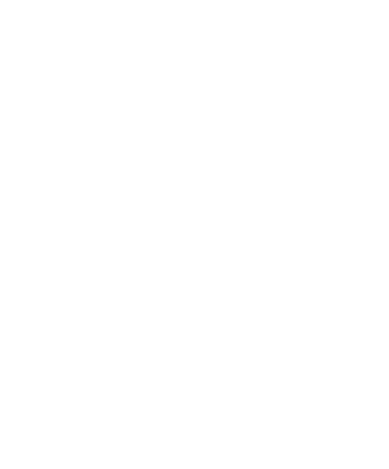

In [6]:
with strategy.scope():
    pred = autoencoder.predict(blurry[:4])
for row in range(2):
    for col in range(2):
        index = row * 2 + col
        plt.subplot(2, 2, index + 1)
        plt.imshow(pred[index])
        plt.axis("off")
plt.tight_layout()
plt.show()
plt.close()